# **Competición Redes Neuronales**

### **Instalación de dependencias**

In [1]:
# pip install numpy matplotlib torch scikit-learn pandas

### **Importar librerías**

In [2]:
import numpy as np
import torch
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import functional as F
import torch.nn as nn
import matplotlib.pyplot as plt

semilla = 42

### **Carga y lectura de datos de entrenamiento**

#### Al presentar un formato de archivo NPZ, contenedor comprimido que almacena arrglos de NumPy, es necesario ver cuantos archivos existen por medio de sus claves de identificación

In [3]:
x = np.load('/Users/miguelflores/Desktop/Redes-Neuronales/data/X_train.npz')
y = np.load('/Users/miguelflores/Desktop/Redes-Neuronales/data/Y_train.npz')
print(x)
print(y)

NpzFile '/Users/miguelflores/Desktop/Redes-Neuronales/data/X_train.npz' with keys: X_tr
NpzFile '/Users/miguelflores/Desktop/Redes-Neuronales/data/Y_train.npz' with keys: Y_tr


In [4]:
# Visualizar las claves
print('Clave de x_train:', x.files,'Clave de y_train:',  y.files)

Clave de x_train: ['X_tr'] Clave de y_train: ['Y_tr']


### **Dimensión**

In [5]:
x = x['X_tr']
y = y['Y_tr']
x.shape, y.shape

((35000, 784), (35000,))

#### En 'x', presentamos 35,000 observaciones con 784 características, las cuales son provenientes del aplanado de imagenes con dimensiones (28x28). En 'y' son las etiquetas que estan asociadas a cada una de las observaciones de x_train.

### **Tipo de datos**

In [6]:
x.dtype, y.dtype

(dtype('float32'), dtype('int64'))

#### Rectificamos el tipo de datos para cada archivo, donde las imágenes deben ser de tipo float, ya que esto permite calcular gradientes y realizar predicciones. Además, se representan como matrices de píxeles que pueden tener valores entre 0 y 255 (escala de grises) o entre 0 y 1 cuando están normalizadas. Las etiquetas deben ser de tipo entero, ya que representan clases, lo que facilita la estimación de las funciones de coste.

### **Contenido de las variables**

In [7]:
# Imagenes
minimo = np.min(x)
maximo = np.max(x)
print(f'Valores de las imagenes:')
print(f'Mínimo: {minimo}, Máximo: {maximo}')

Valores de las imagenes:
Mínimo: 0.0, Máximo: 0.99609375


In [8]:
# Etiquetas
numero_clases = len(np.unique(y))
print(f"El número de clases en el dataset es: {numero_clases}")
np.unique(y)


El número de clases en el dataset es: 2


array([0, 1])

#### Determinamos que las imágenes ya están normalizadas, ya que presentan valores entre 0 y 1. Por lo tanto, no es necesario dividirlas entre 255 (valor máximo en escala de grises). Además, las etiquetas representan dos clases, lo que confirma que se trata de un problema de clasificación binaria.

# **Inicialización**

### **Preparación de datos: División en entrenamiento y validación**

In [9]:
porcentaje_train = 0.1  #10% de validacion

x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = porcentaje_train, random_state = semilla)

#### *Rectificamos división*

In [10]:
# Verificar las dimensiones
print(f"X_train shape: {x_train.shape}, y_train shape: {y_train.shape}")
print(f"X_valid shape: {x_valid.shape}, y_valid shape: {y_valid.shape}")

X_train shape: (31500, 784), y_train shape: (31500,)
X_valid shape: (3500, 784), y_valid shape: (3500,)


### **Cambio de formato**

#### Al corroborar la división en entrenamiento y validación de ambas bases de datos, es posible visualizar que las imagenes siguen presentando un formato aplanado, por lo que para ser apatas para emplearse en una red neuronal convolucional, es necesario sustituirlas a una dimensión donde se presente el número de imagenes por lote, el canal de la imagen, la altura y el ancho. (N,C,H,W).

In [11]:
# Reformatear x_train y x_valid
x_train = torch.from_numpy(x_train).view(-1, 1, 28, 28).to('mps')  # (N, 1, 28, 28)
x_valid = torch.from_numpy(x_valid).view(-1, 1, 28, 28).to('mps')  # (N, 1, 28, 28)

#### Inicialmente presentamos el número de imagenes por lote (-1), donde se situa un valor negativo debido a que nos ayuda a determinar de manera automática el tamaño del lote con base en el número total de elementos del tensor. Después se presenta la dimensión de las imágenes, siendo de 28 x 28, lo cual significa que la imagen es una matriz bidimensional en la que cada entrada representa la intensidad de un píxel. Esto implica que, al haber un solo valor por píxel, la imagen es en escala de grises (1 canal), ya que cada píxel tiene un único valor que define su intensidad (brillo u oscuridad). Además, no hay información adicional de color ni transparencia.

### **Especificamos parámetros de la red**

In [12]:
epoch = 15
batch = 32
aprendizaje = [0.001, 0.01, 0.1]
momentums = [0.8, 0.9, 0.99]

### **TensorDate**

In [13]:
tensor_train = TensorDataset(x_train, torch.from_numpy(y_train).to('mps'))
tensor_valid = TensorDataset(x_valid, torch.from_numpy(y_valid).to('mps'))

### **Dataloaders**

In [14]:
train_loader = DataLoader(tensor_train, batch_size = batch, shuffle=True)  # Para entrenamiento
valid_loader = DataLoader(tensor_valid, batch_size = batch, shuffle=False)  # Para validación

### **Pesos**

In [15]:
w1 = torch.from_numpy(np.random.normal(0, np.sqrt(2.0 / (3 * 3 * 1)), (32, 1, 3, 3)).astype('float32')).to('mps').requires_grad_()
w2 = torch.from_numpy(np.random.normal(0, np.sqrt(2.0 / (3 * 3 * 32)), (64, 32, 3, 3)).astype('float32')).to('mps').requires_grad_()
w_dense = torch.from_numpy(np.random.normal(0, np.sqrt(2.0 / 36864), (36864, 1)).astype('float32')).to('mps').requires_grad_()

### **Sesgos**

In [16]:
b1 = torch.zeros((32,), dtype=torch.float32).to('mps').requires_grad_()
b2 = torch.zeros((64,), dtype=torch.float32).to('mps').requires_grad_()
b_dense = torch.zeros((1,), dtype=torch.float32).to('mps').requires_grad_()

### **Parametros**

In [17]:
parametros = [w1, b1, w2, b2, w_dense, b_dense]

# **Forward**

### **Funciones**

In [18]:
# Funcion de activación
def activation(x, func):
    if func == "relu":
        return F.relu(x)
    elif func == "sigmoid":
        return torch.sigmoid(x)
    else:
        raise ValueError("Función de activación no soportada")

# Función de propagación hacia adelante
def forward(x):
    # Primera convolución
    x = F.conv2d(x, w1, b1, stride=1, padding=0)
    x = activation(x, 'relu')
    # Segunda convolución
    x = F.conv2d(x, w2, b2, stride=1, padding=0)
    x = activation(x, 'relu')
    # Flatten
    x = x.view(x.size(0), -1)  # Aplanar a (batch_size, 36864)
    # Capa densa
    logits = x @ w_dense + b_dense
    return logits

# Función de pérdida
def perdida(y_pred, y_true):
    # Asegurar que y_true tenga la misma forma que y_pred
    y_true = y_true.unsqueeze(-1)  # Convertir de (32) a (32, 1)
    return F.binary_cross_entropy_with_logits(y_pred, y_true.float())

# Función de calculo de precisión
def precision(y_pred, y_true):
    y_true = y_true.unsqueeze(-1)  # Asegurar que las dimensiones coincidan
    predictions = (torch.sigmoid(y_pred) > 0.5).int()  # Convertir logits a etiquetas binarias
    accuracy = (predictions == y_true).float().mean().item()  # Comparar y calcular promedio
    return accuracy

In [18]:
import torch.nn.functional as F

# Probabilidad de dropout
DROPOUT_PROB = 0.5

# Función de activación
def activation(x, func):
    if func == "relu":
        return F.relu(x)
    elif func == "sigmoid":
        return torch.sigmoid(x)
    else:
        raise ValueError("Función de activación no soportada")

# Función de propagación hacia adelante
def forward(x, training=True):
    """
    Propagación hacia adelante con Dropout.
    Args:
        x (torch.Tensor): Entrada.
        training (bool): Si es True, se aplica Dropout.
    Returns:
        logits (torch.Tensor): Salida del modelo.
    """
    # Primera convolución con activación y Dropout
    x = F.conv2d(x, w1, b1, stride=1, padding=0)
    x = activation(x, 'relu')
    if training:
        x = F.dropout(x, p=DROPOUT_PROB, training=training)

    # Segunda convolución con activación y Dropout
    x = F.conv2d(x, w2, b2, stride=1, padding=0)
    x = activation(x, 'relu')
    if training:
        x = F.dropout(x, p=DROPOUT_PROB, training=training)

    # Flatten
    x = x.view(x.size(0), -1)  # Aplanar a (batch_size, 36864)

    # Capa densa con Dropout
    x = F.dropout(x, p=DROPOUT_PROB, training=training)
    logits = x @ w_dense + b_dense

    return logits

# Función de pérdida
def perdida(y_pred, y_true):
    # Asegurar que y_true tenga la misma forma que y_pred
    y_true = y_true.unsqueeze(-1)  # Convertir de (32) a (32, 1)
    return F.binary_cross_entropy_with_logits(y_pred, y_true.float())

# Función de cálculo de precisión
def precision(y_pred, y_true):
    y_true = y_true.unsqueeze(-1)  # Asegurar que las dimensiones coincidan
    predictions = (torch.sigmoid(y_pred) > 0.5).int()  # Convertir logits a etiquetas binarias
    accuracy = (predictions == y_true).float().mean().item()  # Comparar y calcular promedio
    return accuracy

### **Optimizador**

In [131]:
# Optimización
#optimizer = torch.optim.SGD(parametros, lr, mm)

### **Bucle de Entrenamiento**

In [19]:
import csv

# Parámetros para Early Stopping
iteracion_sin_mejora = 3  # Número de épocas sin mejora permitidas

# Variables para almacenar el mejor resultado global
best_hyperparameters = None
best_validation_accuracy_global = 0.0

# Diccionario para almacenar los resultados
results = []

# Loop para probar combinaciones de learning_rate y momentum
for lr in aprendizaje:
    for mm in momentums:
        print(f"\n------- Probando combinación: learning_rate={lr}, momentum={mm} -------")

        # Configurar optimizador con los valores actuales
        optimizer = torch.optim.SGD(parametros, lr=lr, momentum=mm)

        # Reiniciar métricas y variables
        train_losses = []
        train_accuracies = []
        valid_losses = []
        valid_accuracies = []
        best_validation_accuracy = 0.0
        epochs_without_improvement = 0

        # Entrenamiento con Early Stopping
        for epoch in range(epoch):
            ce = 0.0  # Pérdida acumulada
            acc = 0.0  # Precisión acumulada

            # Entrenamiento por lotes
            for x_batch, y_batch in train_loader:
                y_pred = forward(x_batch, training=True)  # Activar Dropout
                loss = perdida(y_pred, y_batch)  # Pérdida
                accuracy = precision(y_pred, y_batch)  # Precisión del mini-lote

                # Gradientes y optimización
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                ce += loss.item()
                acc += accuracy

            # Guardar métricas de entrenamiento
            train_losses.append(ce / len(train_loader))
            train_accuracies.append(acc / len(train_loader))

            # Evaluación en el conjunto de validación
            test_loss = 0.0
            test_acc = 0.0
            for x_test, y_test in valid_loader:
                y_pred = forward(x_test, training=False)  # Desactivar Dropout
                test_loss += perdida(y_pred, y_test).item()
                test_acc += precision(y_pred, y_test)

            # Guardar métricas de validación
            valid_losses.append(test_loss / len(valid_loader))
            valid_accuracies.append(test_acc / len(valid_loader))

            # Guardar resultados en el diccionario
            results.append({
                "learning_rate": lr,
                "momentum": mm,
                "epoch": epoch + 1,
                "train_loss": train_losses[-1],
                "train_accuracy": train_accuracies[-1],
                "valid_loss": valid_losses[-1],
                "valid_accuracy": valid_accuracies[-1]
            })

            # Resultados
            print(f"[learning_rate={lr}, momentum={mm}] Epoch {epoch + 1}/{epoch}, "
                  f"Train Loss: {ce / len(train_loader):.4f}, "
                  f"Train Accuracy: {acc / len(train_loader) * 100:.2f}%, "
                  f"Validation Loss: {test_loss / len(valid_loader):.4f}, "
                  f"Validation Accuracy: {test_acc / len(valid_loader) * 100:.2f}%")

            # Early Stopping: verificar si hay mejora en la precisión de validación
            if test_acc / len(valid_loader) > best_validation_accuracy:
                best_validation_accuracy = test_acc / len(valid_loader)
                epochs_without_improvement = 0  # Reiniciar contador si hay mejora
                print(f"*** Mejor precisión de validación encontrada: {best_validation_accuracy * 100:.2f}% ***")
            else:
                epochs_without_improvement += 1
                print(f"No hubo mejora en la precisión de validación. "
                      f"Épocas sin mejora: {epochs_without_improvement}/{iteracion_sin_mejora}")

            # Detener el entrenamiento si no hay mejora por `iteracion_sin_mejora` épocas consecutivas
            if epochs_without_improvement >= iteracion_sin_mejora:
                print(f"*** Early stopping activado. Mejor precisión de validación: {best_validation_accuracy * 100:.2f}% ***")
                break

        # Comparar el mejor resultado con el global
        if best_validation_accuracy > best_validation_accuracy_global:
            best_validation_accuracy_global = best_validation_accuracy
            best_hyperparameters = (lr, mm)

# Guardar los resultados en el diccionario
print("\nResultados almacenados.")

# Resultado final
if best_hyperparameters:
    print(f"\n------- Mejor combinación encontrada -------")
    print(f"Learning Rate: {best_hyperparameters[0]}, Momentum: {best_hyperparameters[1]}, "
          f"Validation Accuracy: {best_validation_accuracy_global * 100:.2f}%")
else:
    print("\nNo se encontró ninguna combinación con mejora.")


------- Probando combinación: learning_rate=0.001, momentum=0.8 -------
[learning_rate=0.001, momentum=0.8] Epoch 1/0, Train Loss: 0.3806, Train Accuracy: 83.76%, Validation Loss: 0.3069, Validation Accuracy: 88.56%
*** Mejor precisión de validación encontrada: 88.56% ***
[learning_rate=0.001, momentum=0.8] Epoch 2/1, Train Loss: 0.2740, Train Accuracy: 88.83%, Validation Loss: 0.2341, Validation Accuracy: 92.79%
*** Mejor precisión de validación encontrada: 92.79% ***
[learning_rate=0.001, momentum=0.8] Epoch 3/2, Train Loss: 0.2169, Train Accuracy: 91.35%, Validation Loss: 0.2089, Validation Accuracy: 92.93%
*** Mejor precisión de validación encontrada: 92.93% ***
[learning_rate=0.001, momentum=0.8] Epoch 4/3, Train Loss: 0.1826, Train Accuracy: 92.99%, Validation Loss: 0.1888, Validation Accuracy: 92.90%
No hubo mejora en la precisión de validación. Épocas sin mejora: 1/3
[learning_rate=0.001, momentum=0.8] Epoch 5/4, Train Loss: 0.1625, Train Accuracy: 93.80%, Validation Loss: 0.1

In [ ]:
re

In [133]:
# Parámetros para Early Stopping
iteracion_sin_mejora = 3  # Número de épocas sin mejora permitidas

# Variables para almacenar el mejor resultado global
best_hyperparameters = None
best_validation_accuracy_global = 0.0

# Loop para probar combinaciones de learning_rate y momentum
for lr in aprendizaje:
    for mm in momentums:
        print(f"\n------- Probando combinación: learning_rate={lr}, momentum={mm} -------")

        # Configurar optimizador con los valores actuales
        optimizer = torch.optim.SGD(parametros, lr=lr, momentum=mm)

        # Reiniciar métricas y variables
        train_losses = []
        train_accuracies = []
        valid_losses = []
        valid_accuracies = []
        best_validation_accuracy = 0.0
        epochs_without_improvement = 0

        # Entrenamiento con Early Stopping
        for epoch in range(epoch):
            ce = 0.0  # Pérdida acumulada
            acc = 0.0  # Precisión acumulada

            # Entrenamiento por lotes
            for x_batch, y_batch in train_loader:
                y_pred = forward(x_batch)  # Forward
                loss = perdida(y_pred, y_batch)  # Pérdida
                accuracy = precision(y_pred, y_batch)  # Precisión del mini-lote

                # Gradientes y optimización
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                ce += loss.item()
                acc += accuracy

            # Guardar métricas de entrenamiento
            train_losses.append(ce / len(train_loader))
            train_accuracies.append(acc / len(train_loader))

            # Evaluación en el conjunto de validación
            test_loss = 0.0
            test_acc = 0.0
            for x_test, y_test in valid_loader:
                y_pred = forward(x_test)
                test_loss += perdida(y_pred, y_test).item()
                test_acc += precision(y_pred, y_test)

            # Guardar métricas de validación
            valid_losses.append(test_loss / len(valid_loader))
            valid_accuracies.append(test_acc / len(valid_loader))

            # Resultados
            print(f"[learning_rate={lr}, momentum={mm}] Epoch {epoch + 1}/{epoch}, "
                  f"Train Loss: {ce / len(train_loader):.4f}, "
                  f"Train Accuracy: {acc / len(train_loader) * 100:.2f}%, "
                  f"Validation Loss: {test_loss / len(valid_loader):.4f}, "
                  f"Validation Accuracy: {test_acc / len(valid_loader) * 100:.2f}%")

            # Early Stopping: verificar si hay mejora en la precisión de validación
            if test_acc / len(valid_loader) > best_validation_accuracy:
                best_validation_accuracy = test_acc / len(valid_loader)
                epochs_without_improvement = 0  # Reiniciar contador si hay mejora
                print(f"*** Mejor precisión de validación encontrada: {best_validation_accuracy * 100:.2f}% ***")
            else:
                epochs_without_improvement += 1
                print(f"No hubo mejora en la precisión de validación. "
                      f"Épocas sin mejora: {epochs_without_improvement}/{iteracion_sin_mejora}")

            # Detener el entrenamiento si no hay mejora por `iteracion_sin_mejora` épocas consecutivas
            if epochs_without_improvement >= iteracion_sin_mejora:
                print(f"*** Early stopping activado. Mejor precisión de validación: {best_validation_accuracy * 100:.2f}% ***")
                break

        # Comparar el mejor resultado con el global
        if best_validation_accuracy > best_validation_accuracy_global:
            best_validation_accuracy_global = best_validation_accuracy
            best_hyperparameters = (lr, mm)

# Resultado final
print(f"\n------- Mejor combinación encontrada -------")
print(f"Learning Rate: {best_hyperparameters[0]}, Momentum: {best_hyperparameters[1]}, "
      f"Validation Accuracy: {best_validation_accuracy_global * 100:.2f}%")


------- Probando combinación: learning_rate=0.001, momentum=0.8 -------
[learning_rate=0.001, momentum=0.8] Epoch 1/0, Train Loss: 0.2132, Train Accuracy: 91.75%, Validation Loss: 0.1391, Validation Accuracy: 94.94%
*** Mejor precisión de validación encontrada: 94.94% ***
[learning_rate=0.001, momentum=0.8] Epoch 2/1, Train Loss: 0.1158, Train Accuracy: 96.08%, Validation Loss: 0.1026, Validation Accuracy: 96.22%
*** Mejor precisión de validación encontrada: 96.22% ***
[learning_rate=0.001, momentum=0.8] Epoch 3/2, Train Loss: 0.0931, Train Accuracy: 96.88%, Validation Loss: 0.0933, Validation Accuracy: 96.62%
*** Mejor precisión de validación encontrada: 96.62% ***
[learning_rate=0.001, momentum=0.8] Epoch 4/3, Train Loss: 0.0815, Train Accuracy: 97.28%, Validation Loss: 0.0858, Validation Accuracy: 96.96%
*** Mejor precisión de validación encontrada: 96.96% ***
[learning_rate=0.001, momentum=0.8] Epoch 5/4, Train Loss: 0.0744, Train Accuracy: 97.57%, Validation Loss: 0.0797, Validat

KeyboardInterrupt: 

### **Función test**

In [19]:
import csv

# Parámetros para Early Stopping
iteracion_sin_mejora = 3  # Número de épocas sin mejora permitidas

# Variables para almacenar el mejor resultado global
best_hyperparameters = None
best_validation_accuracy_global = 0.0

# Diccionario para almacenar los resultados
results = []

# Loop para probar combinaciones de learning_rate y momentum
for lr in aprendizaje:
    for mm in momentums:
        print(f"\n------- Probando combinación: learning_rate={lr}, momentum={mm} -------")

        # Configurar optimizador con los valores actuales
        optimizer = torch.optim.SGD(parametros, lr=lr, momentum=mm)

        # Reiniciar métricas y variables
        train_losses = []
        train_accuracies = []
        valid_losses = []
        valid_accuracies = []
        best_validation_accuracy = 0.0
        epochs_without_improvement = 0

        # Entrenamiento con Early Stopping
        for epoch in range(epoch):
            ce = 0.0  # Pérdida acumulada
            acc = 0.0  # Precisión acumulada

            # Entrenamiento por lotes
            for x_batch, y_batch in train_loader:
                y_pred = forward(x_batch)  # Forward
                loss = perdida(y_pred, y_batch)  # Pérdida
                accuracy = precision(y_pred, y_batch)  # Precisión del mini-lote

                # Gradientes y optimización
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                ce += loss.item()
                acc += accuracy

            # Guardar métricas de entrenamiento
            train_losses.append(ce / len(train_loader))
            train_accuracies.append(acc / len(train_loader))

            # Evaluación en el conjunto de validación
            test_loss = 0.0
            test_acc = 0.0
            for x_test, y_test in valid_loader:
                y_pred = forward(x_test)
                test_loss += perdida(y_pred, y_test).item()
                test_acc += precision(y_pred, y_test)

            # Guardar métricas de validación
            valid_losses.append(test_loss / len(valid_loader))
            valid_accuracies.append(test_acc / len(valid_loader))

            # Guardar resultados en el diccionario
            results.append({
                "learning_rate": lr,
                "momentum": mm,
                "epoch": epoch + 1,
                "train_loss": train_losses[-1],
                "train_accuracy": train_accuracies[-1],
                "valid_loss": valid_losses[-1],
                "valid_accuracy": valid_accuracies[-1]
            })

            # Resultados
            print(f"[learning_rate={lr}, momentum={mm}] Epoch {epoch + 1}/{epoch}, "
                  f"Train Loss: {ce / len(train_loader):.4f}, "
                  f"Train Accuracy: {acc / len(train_loader) * 100:.2f}%, "
                  f"Validation Loss: {test_loss / len(valid_loader):.4f}, "
                  f"Validation Accuracy: {test_acc / len(valid_loader) * 100:.2f}%")

            # Early Stopping: verificar si hay mejora en la precisión de validación
            if test_acc / len(valid_loader) > best_validation_accuracy:
                best_validation_accuracy = test_acc / len(valid_loader)
                epochs_without_improvement = 0  # Reiniciar contador si hay mejora
                print(f"*** Mejor precisión de validación encontrada: {best_validation_accuracy * 100:.2f}% ***")
            else:
                epochs_without_improvement += 1
                print(f"No hubo mejora en la precisión de validación. "
                      f"Épocas sin mejora: {epochs_without_improvement}/{iteracion_sin_mejora}")

            # Detener el entrenamiento si no hay mejora por `iteracion_sin_mejora` épocas consecutivas
            if epochs_without_improvement >= iteracion_sin_mejora:
                print(f"*** Early stopping activado. Mejor precisión de validación: {best_validation_accuracy * 100:.2f}% ***")
                break

        # Comparar el mejor resultado con el global
        if best_validation_accuracy > best_validation_accuracy_global:
            best_validation_accuracy_global = best_validation_accuracy
            best_hyperparameters = (lr, mm)

# Guardar los resultados en el diccionario
print("\nResultados almacenados.")

# Resultado final
if best_hyperparameters:
    print(f"\n------- Mejor combinación encontrada -------")
    print(f"Learning Rate: {best_hyperparameters[0]}, Momentum: {best_hyperparameters[1]}, "
          f"Validation Accuracy: {best_validation_accuracy_global * 100:.2f}%")
else:
    print("\nNo se encontró ninguna combinación con mejora.")



------- Probando combinación: learning_rate=0.001, momentum=0.8 -------
[learning_rate=0.001, momentum=0.8] Epoch 1/0, Train Loss: 0.2393, Train Accuracy: 90.62%, Validation Loss: 0.1870, Validation Accuracy: 92.98%
*** Mejor precisión de validación encontrada: 92.98% ***
[learning_rate=0.001, momentum=0.8] Epoch 2/1, Train Loss: 0.1344, Train Accuracy: 95.40%, Validation Loss: 0.1204, Validation Accuracy: 95.51%
*** Mejor precisión de validación encontrada: 95.51% ***
[learning_rate=0.001, momentum=0.8] Epoch 3/2, Train Loss: 0.1023, Train Accuracy: 96.54%, Validation Loss: 0.0985, Validation Accuracy: 96.34%
*** Mejor precisión de validación encontrada: 96.34% ***
[learning_rate=0.001, momentum=0.8] Epoch 4/3, Train Loss: 0.0872, Train Accuracy: 97.14%, Validation Loss: 0.0992, Validation Accuracy: 96.48%
*** Mejor precisión de validación encontrada: 96.48% ***
[learning_rate=0.001, momentum=0.8] Epoch 5/4, Train Loss: 0.0793, Train Accuracy: 97.29%, Validation Loss: 0.0875, Validat

In [20]:
results

[{'learning_rate': 0.001,
  'momentum': 0.8,
  'epoch': 1,
  'train_loss': 0.23932912280868152,
  'train_accuracy': 0.9061865482233502,
  'valid_loss': 0.1870357059958306,
  'valid_accuracy': 0.9298295454545454},
 {'learning_rate': 0.001,
  'momentum': 0.8,
  'epoch': 2,
  'train_loss': 0.13444311718272073,
  'train_accuracy': 0.954039763133538,
  'valid_loss': 0.12036579332568428,
  'valid_accuracy': 0.9551136363636363},
 {'learning_rate': 0.001,
  'momentum': 0.8,
  'epoch': 3,
  'train_loss': 0.1022796863548193,
  'train_accuracy': 0.9654187817258884,
  'valid_loss': 0.09848465477116405,
  'valid_accuracy': 0.9633522727272728},
 {'learning_rate': 0.001,
  'momentum': 0.8,
  'epoch': 4,
  'train_loss': 0.08721998301689243,
  'train_accuracy': 0.9713832487309645,
  'valid_loss': 0.09917523032054305,
  'valid_accuracy': 0.9647727272727272},
 {'learning_rate': 0.001,
  'momentum': 0.8,
  'epoch': 5,
  'train_loss': 0.07934706177997408,
  'train_accuracy': 0.9729060913705584,
  'valid_lo

In [111]:
# Parámetros para Early Stopping
iteracion_sin_mejora = 3  # Número de épocas sin mejora permitidas

# Variables para almacenar el mejor resultado global
best_hyperparameters = None
best_validation_accuracy_global = 0.0
results = []
# Loop para probar combinaciones de learning_rate y momentum
for lr in aprendizaje:
    for mm in momentums:
        print(f"\n------- Probando combinación: learning_rate={lr}, momentum={mm} -------")

        # Configurar optimizador con los valores actuales
        optimizer = torch.optim.SGD(parametros, lr=lr, momentum=mm)

        # Reiniciar métricas y variables
        train_losses = []
        train_accuracies = []
        valid_losses = []
        valid_accuracies = []
        best_validation_accuracy = 0.0
        epochs_without_improvement = 0

        # Entrenamiento con Early Stopping
        for epoch in range(epoch):
            ce = 0.0  # Pérdida acumulada
            acc = 0.0  # Precisión acumulada

            # Entrenamiento por lotes
            for x_batch, y_batch in train_loader:
                y_pred = forward(x_batch)  # Forward
                loss = perdida(y_pred, y_batch)  # Pérdida
                accuracy = precision(y_pred, y_batch)  # Precisión del mini-lote

                # Gradientes y optimización
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                ce += loss.item()
                acc += accuracy
            # Guardar métricas de entrenamiento
            train_loss_epoch = ce / len(train_loader)
            train_accuracy_epoch = acc / len(train_loader)
            train_losses.append(train_loss_epoch)
            train_accuracies.append(train_accuracy_epoch)

            # Evaluación en el conjunto de validación
            test_loss = 0.0
            test_acc = 0.0
            for x_test, y_test in valid_loader:
                y_pred = forward(x_test)
                test_loss += perdida(y_pred, y_test).item()
                test_acc += precision(y_pred, y_test)

            # Guardar métricas de validación
            valid_losses.append(test_loss / len(valid_loader))
            valid_accuracies.append(test_acc / len(valid_loader))

            # Resultados
            print(f"[learning_rate={lr}, momentum={mm}] Epoch {epoch + 1}/{epoch}, "
                  f"Train Loss: {ce / len(train_loader):.4f}, "
                  f"Train Accuracy: {acc / len(train_loader) * 100:.2f}%, "
                  f"Validation Loss: {test_loss / len(valid_loader):.4f}, "
                  f"Validation Accuracy: {test_acc / len(valid_loader) * 100:.2f}%")

            results.append({
                "learning_rate": lr,
                "momentum": mm,
                "epoch": epoch + 1,
                "train_loss": train_loss_epoch,
                "train_accuracy": train_accuracy_epoch,
                "valid_loss": valid_loss_epoch,
                "valid_accuracy": valid_accuracy_epoch
            })
            
            # Early Stopping: verificar si hay mejora en la precisión de validación
            if test_acc / len(valid_loader) > best_validation_accuracy:
                best_validation_accuracy = test_acc / len(valid_loader)
                epochs_without_improvement = 0  # Reiniciar contador si hay mejora
                print(f"*** Mejor precisión de validación encontrada: {best_validation_accuracy * 100:.2f}% ***")
            else:
                epochs_without_improvement += 1
                print(f"No hubo mejora en la precisión de validación. "
                      f"Épocas sin mejora: {epochs_without_improvement}/{iteracion_sin_mejora}")

            # Detener el entrenamiento si no hay mejora por `iteracion_sin_mejora` épocas consecutivas
            if epochs_without_improvement >= iteracion_sin_mejora:
                print(f"*** Early stopping activado. Mejor precisión de validación: {best_validation_accuracy * 100:.2f}% ***")
                break

        # Comparar el mejor resultado con el global
        if best_validation_accuracy > best_validation_accuracy_global:
            best_validation_accuracy_global = best_validation_accuracy
            best_hyperparameters = (lr, mm)

# Resultado final
print(f"\n------- Mejor combinación encontrada -------")
print(f"Learning Rate: {best_hyperparameters[0]}, Momentum: {best_hyperparameters[1]}, "
      f"Validation Accuracy: {best_validation_accuracy_global * 100:.2f}%")


------- Probando combinación: learning_rate=0.001, momentum=0.8 -------

------- Probando combinación: learning_rate=0.001, momentum=0.9 -------

------- Probando combinación: learning_rate=0.001, momentum=0.99 -------

------- Probando combinación: learning_rate=0.01, momentum=0.8 -------

------- Probando combinación: learning_rate=0.01, momentum=0.9 -------

------- Probando combinación: learning_rate=0.01, momentum=0.99 -------

------- Probando combinación: learning_rate=0.1, momentum=0.8 -------

------- Probando combinación: learning_rate=0.1, momentum=0.9 -------

------- Probando combinación: learning_rate=0.1, momentum=0.99 -------

------- Mejor combinación encontrada -------


TypeError: 'NoneType' object is not subscriptable

In [112]:
import csv

# Parámetros para Early Stopping
iteracion_sin_mejora = 3  # Número de épocas sin mejora permitidas

# Variables para almacenar resultados
results = []  # Lista para almacenar los resultados de cada combinación
best_hyperparameters = None
best_validation_accuracy_global = 0.0

# Loop para probar combinaciones de learning_rate y momentum
for lr in aprendizaje:
    for mm in momentums:
        print(f"\n------- Probando combinación: learning_rate={lr}, momentum={mm} -------")

        # Configurar optimizador con los valores actuales
        optimizer = torch.optim.SGD(parametros, lr=lr, momentum=mm)

        # Reiniciar métricas y variables
        train_losses = []
        train_accuracies = []
        valid_losses = []
        valid_accuracies = []
        best_validation_accuracy = 0.0
        epochs_without_improvement = 0

        # Entrenamiento con Early Stopping
        for epoch in range(epoch):
            ce = 0.0  # Pérdida acumulada
            acc = 0.0  # Precisión acumulada

            # Entrenamiento por lotes
            for x_batch, y_batch in train_loader:
                y_pred = forward(x_batch)  # Forward
                loss = perdida(y_pred, y_batch)  # Pérdida
                accuracy = precision(y_pred, y_batch)  # Precisión del mini-lote

                # Gradientes y optimización
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                ce += loss.item()
                acc += accuracy

            # Guardar métricas de entrenamiento
            train_loss_epoch = ce / len(train_loader)
            train_accuracy_epoch = acc / len(train_loader)
            train_losses.append(train_loss_epoch)
            train_accuracies.append(train_accuracy_epoch)

            # Evaluación en el conjunto de validación
            test_loss = 0.0
            test_acc = 0.0
            for x_test, y_test in valid_loader:
                y_pred = forward(x_test)
                test_loss += perdida(y_pred, y_test).item()
                test_acc += precision(y_pred, y_test)

            # Guardar métricas de validación
            valid_loss_epoch = test_loss / len(valid_loader)
            valid_accuracy_epoch = test_acc / len(valid_loader)
            valid_losses.append(valid_loss_epoch)
            valid_accuracies.append(valid_accuracy_epoch)

            # Guardar resultados en la lista
            results.append({
                "learning_rate": lr,
                "momentum": mm,
                "epoch": epoch + 1,
                "train_loss": train_loss_epoch,
                "train_accuracy": train_accuracy_epoch,
                "valid_loss": valid_loss_epoch,
                "valid_accuracy": valid_accuracy_epoch
            })

            # Early Stopping: verificar si hay mejora en la precisión de validación
            if valid_accuracy_epoch > best_validation_accuracy:
                best_validation_accuracy = valid_accuracy_epoch
                epochs_without_improvement = 0  # Reiniciar contador si hay mejora
                print(f"*** Mejor precisión de validación encontrada: {best_validation_accuracy * 100:.2f}% ***")
            else:
                epochs_without_improvement += 1
                print(f"No hubo mejora en la precisión de validación. "
                      f"Épocas sin mejora: {epochs_without_improvement}/{iteracion_sin_mejora}")

            # Detener el entrenamiento si no hay mejora por `iteracion_sin_mejora` épocas consecutivas
            if epochs_without_improvement >= iteracion_sin_mejora:
                print(f"*** Early stopping activado. Mejor precisión de validación: {best_validation_accuracy * 100:.2f}% ***")
                break

        # Comparar el mejor resultado con el global
        if best_validation_accuracy > best_validation_accuracy_global:
            best_validation_accuracy_global = best_validation_accuracy
            best_hyperparameters = (lr, mm)

# Guardar resultados en un archivo CSV
output_file = "training_results.csv"
keys = ["learning_rate", "momentum", "epoch", "train_loss", "train_accuracy", "valid_loss", "valid_accuracy"]
with open(output_file, mode="w", newline="") as file:
    writer = csv.DictWriter(file, fieldnames=keys)
    writer.writeheader()
    writer.writerows(results)

print(f"\nResultados guardados en {output_file}")

# Resultado final
if best_hyperparameters:
    print(f"\n------- Mejor combinación encontrada -------")
    print(f"Learning Rate: {best_hyperparameters[0]}, Momentum: {best_hyperparameters[1]}, "
          f"Validation Accuracy: {best_validation_accuracy_global * 100:.2f}%")
else:
    print("\nNo se encontró ninguna combinación con mejora.")


------- Probando combinación: learning_rate=0.001, momentum=0.8 -------

------- Probando combinación: learning_rate=0.001, momentum=0.9 -------

------- Probando combinación: learning_rate=0.001, momentum=0.99 -------

------- Probando combinación: learning_rate=0.01, momentum=0.8 -------

------- Probando combinación: learning_rate=0.01, momentum=0.9 -------

------- Probando combinación: learning_rate=0.01, momentum=0.99 -------

------- Probando combinación: learning_rate=0.1, momentum=0.8 -------

------- Probando combinación: learning_rate=0.1, momentum=0.9 -------

------- Probando combinación: learning_rate=0.1, momentum=0.99 -------

Resultados guardados en training_results.csv

No se encontró ninguna combinación con mejora.


In [100]:
# Función para guardar predicciones
def save_predictions(X_te):
    """
    Genera y guarda las predicciones en un archivo comprimido.

    Args:
        X_te: Conjunto de imágenes de prueba (torch.Tensor).
    """
    # Asegurar que X_te tiene la forma correcta
    X_te = X_te.view(-1, 1, 28, 28).to('mps')  # Ajustar forma si es necesario
    with torch.no_grad():
        # Forward para generar predicciones
        logits = forward(X_te)  # Pasar las imágenes por el modelo
        probabilities = torch.sigmoid(logits)  # Convertir logits a probabilidades
        Y_te = (probabilities > 0.5).int().cpu().numpy().flatten()  # Convertir a etiquetas binarias (0 o 1)

    # Guardar predicciones en un archivo comprimido
    np.savez_compressed('Y_test', Y_te=Y_te)
    print("Predicciones guardadas en 'Y_test.npz'.")


------- Probando combinación: learning_rate=0.001, momentum=0.8 -------

------- Probando combinación: learning_rate=0.001, momentum=0.9 -------

------- Probando combinación: learning_rate=0.001, momentum=0.99 -------

------- Probando combinación: learning_rate=0.01, momentum=0.8 -------

------- Probando combinación: learning_rate=0.01, momentum=0.9 -------

------- Probando combinación: learning_rate=0.01, momentum=0.99 -------

------- Probando combinación: learning_rate=0.1, momentum=0.8 -------

------- Probando combinación: learning_rate=0.1, momentum=0.9 -------

------- Probando combinación: learning_rate=0.1, momentum=0.99 -------

No se encontró ninguna combinación con mejora en validación.


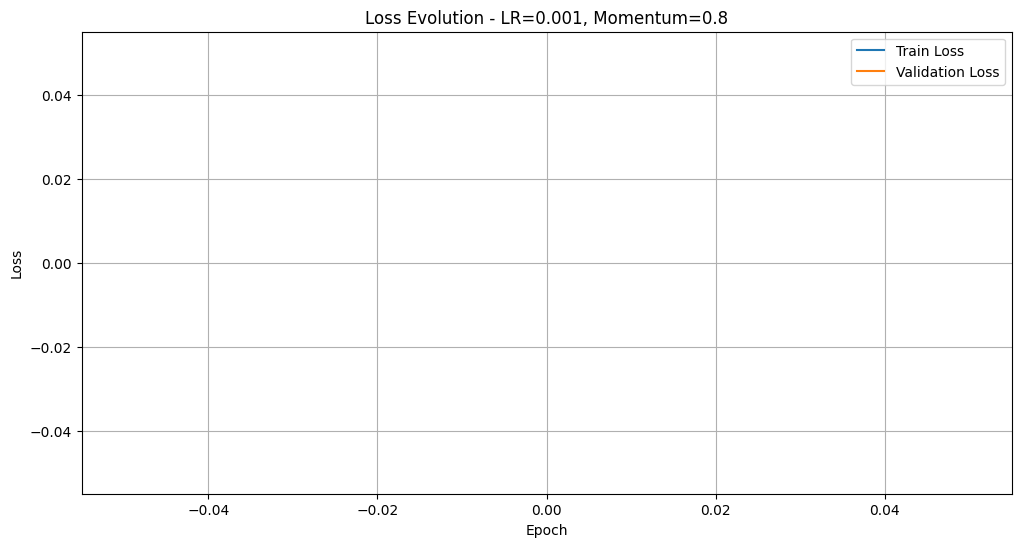

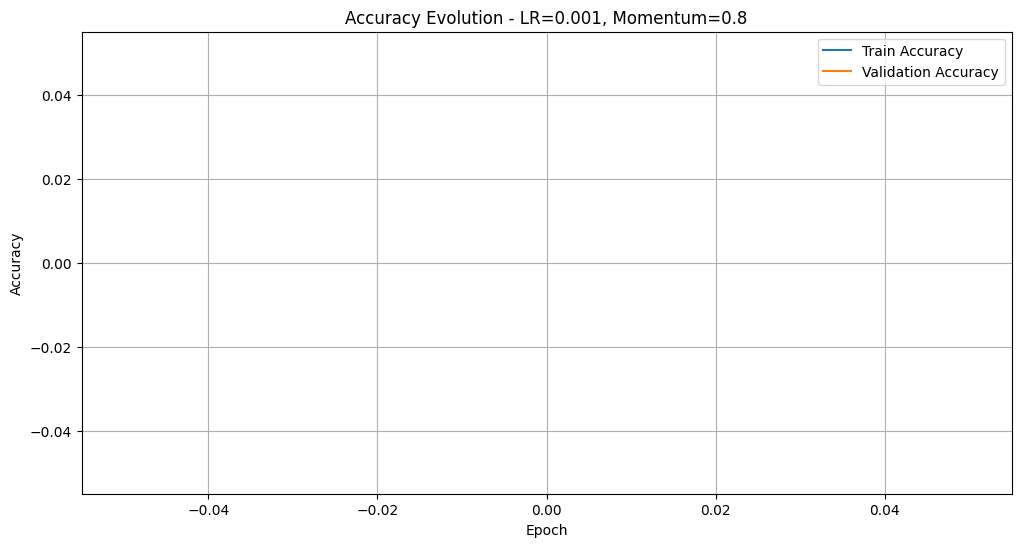

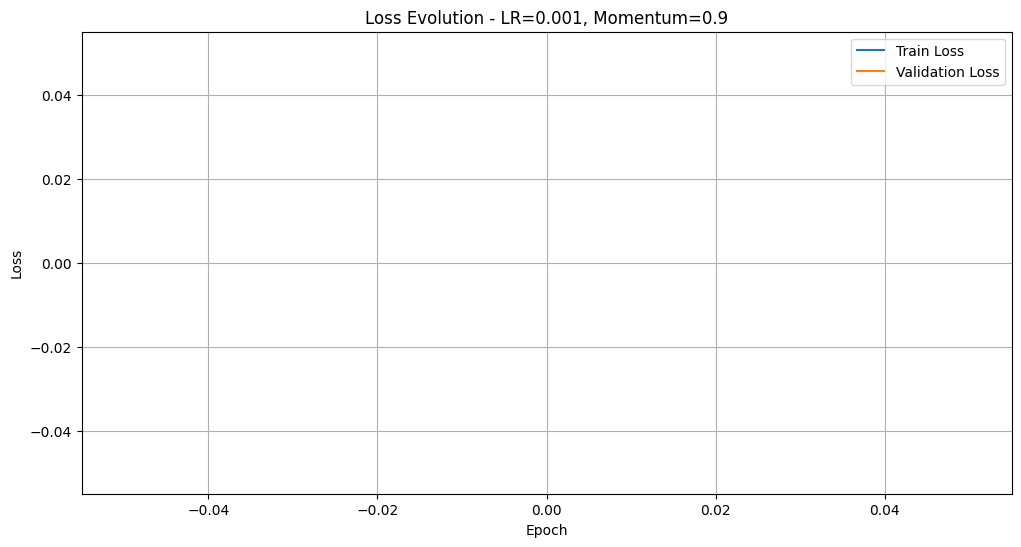

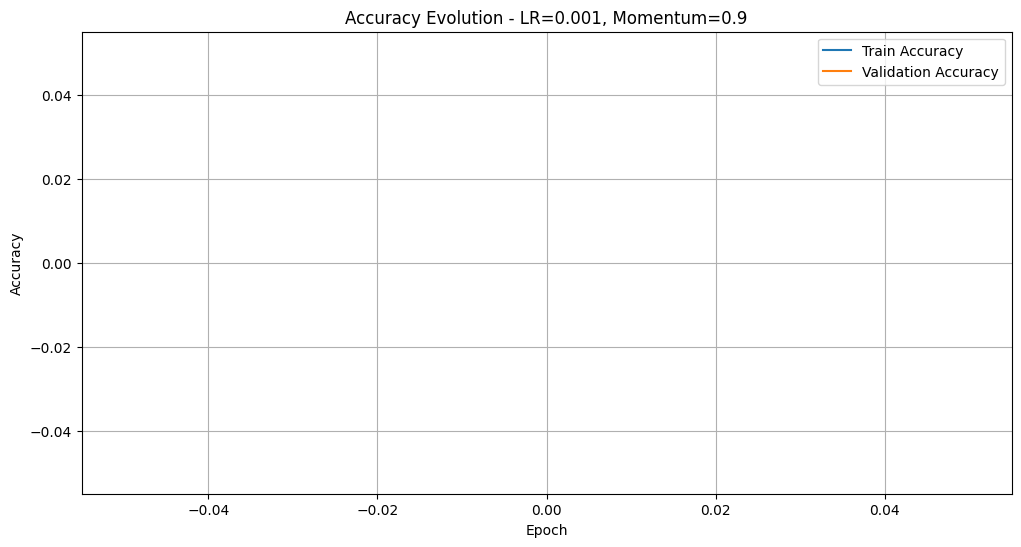

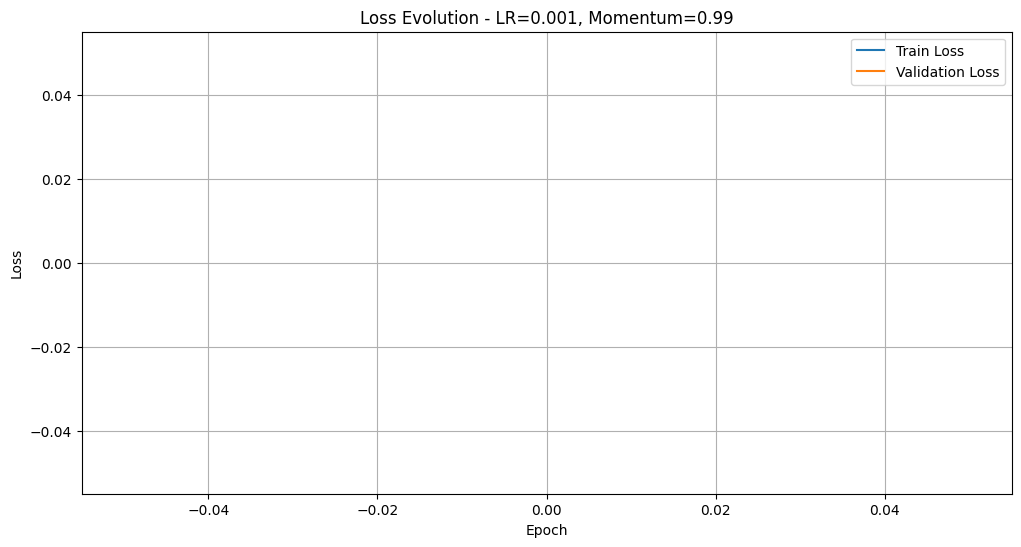

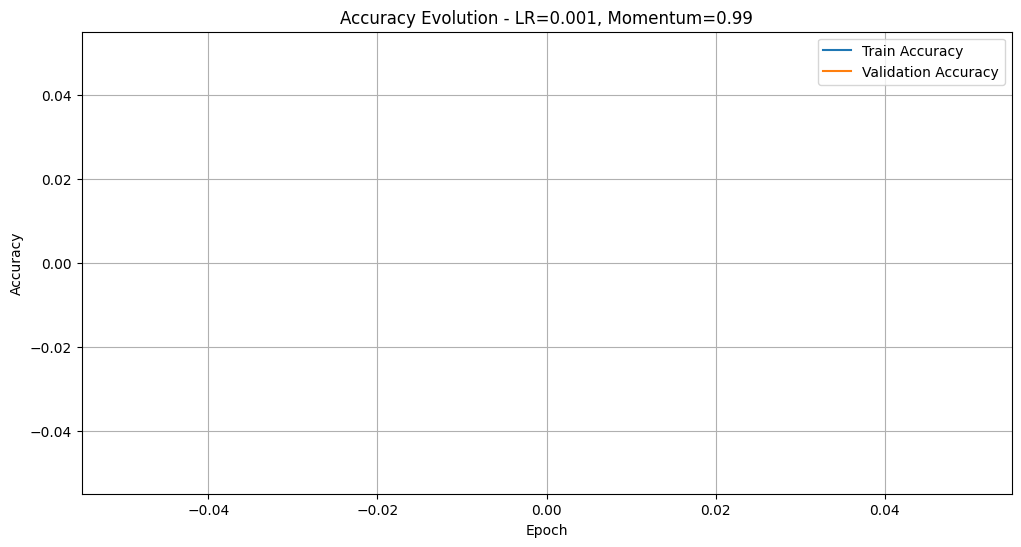

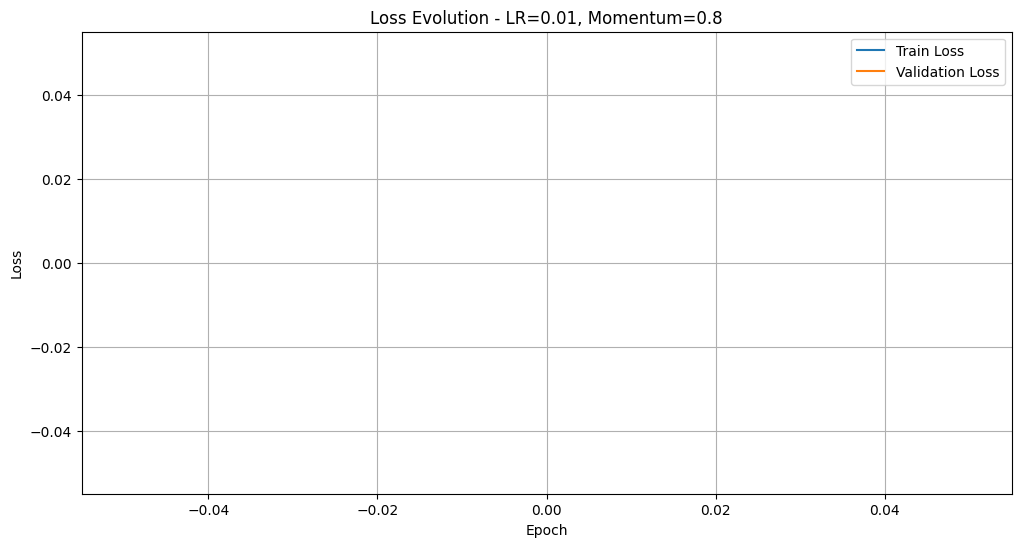

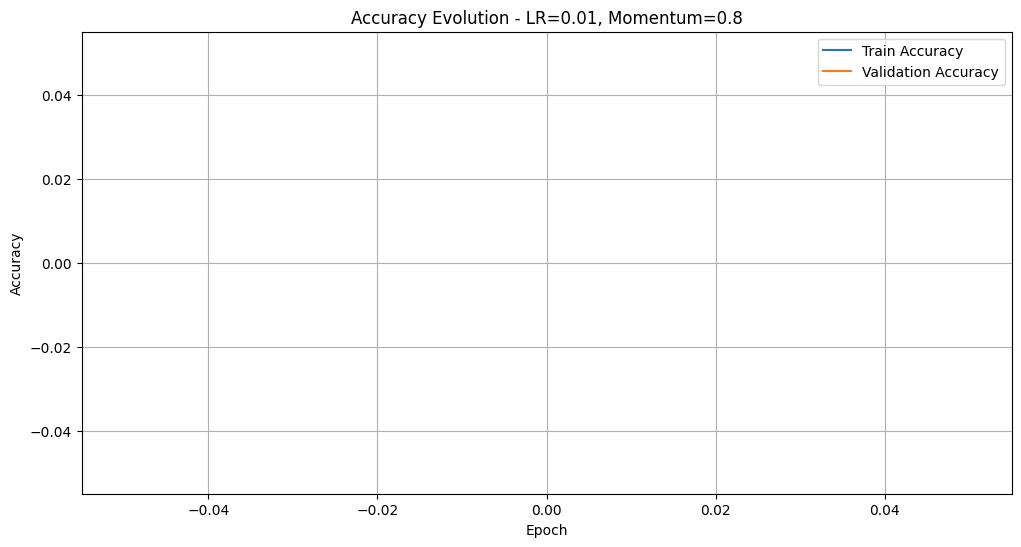

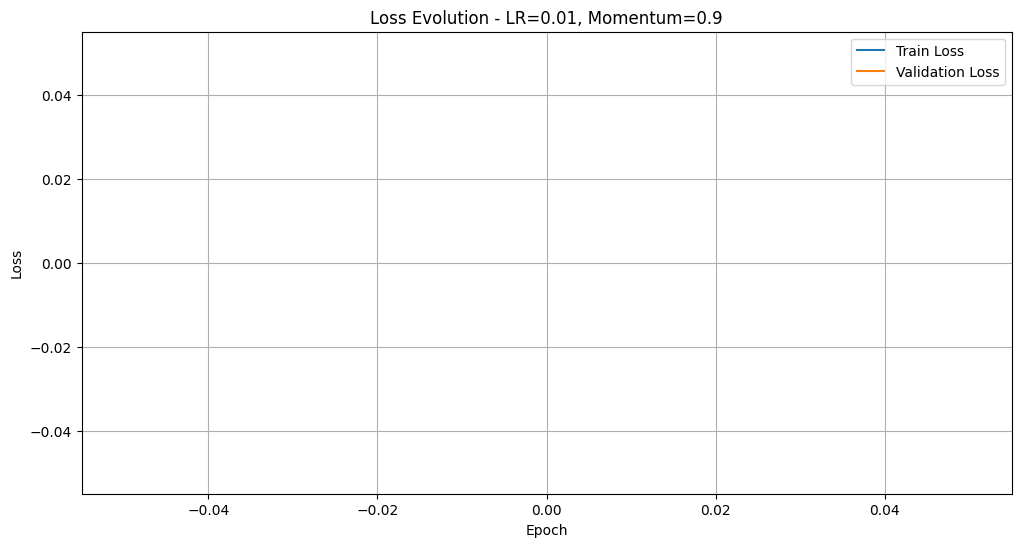

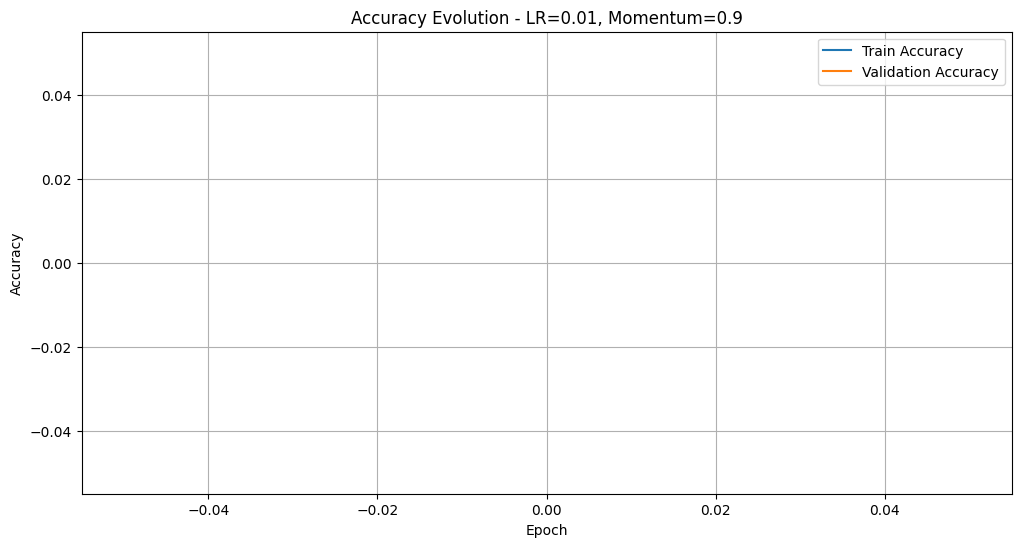

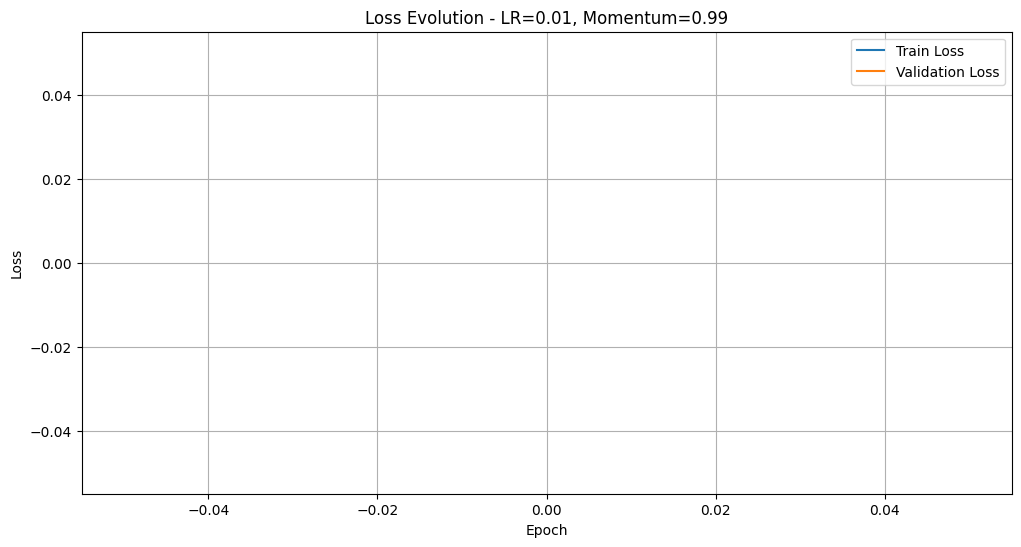

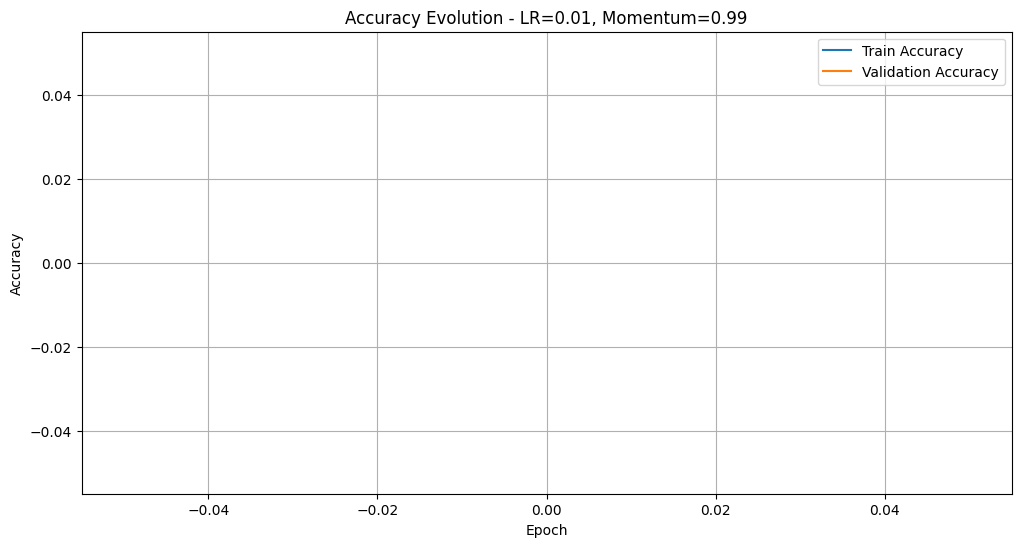

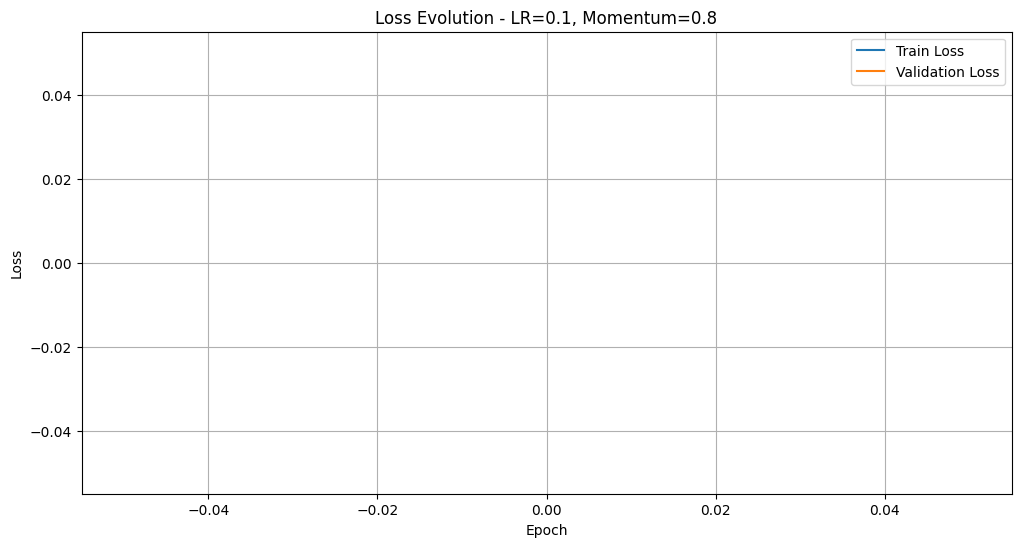

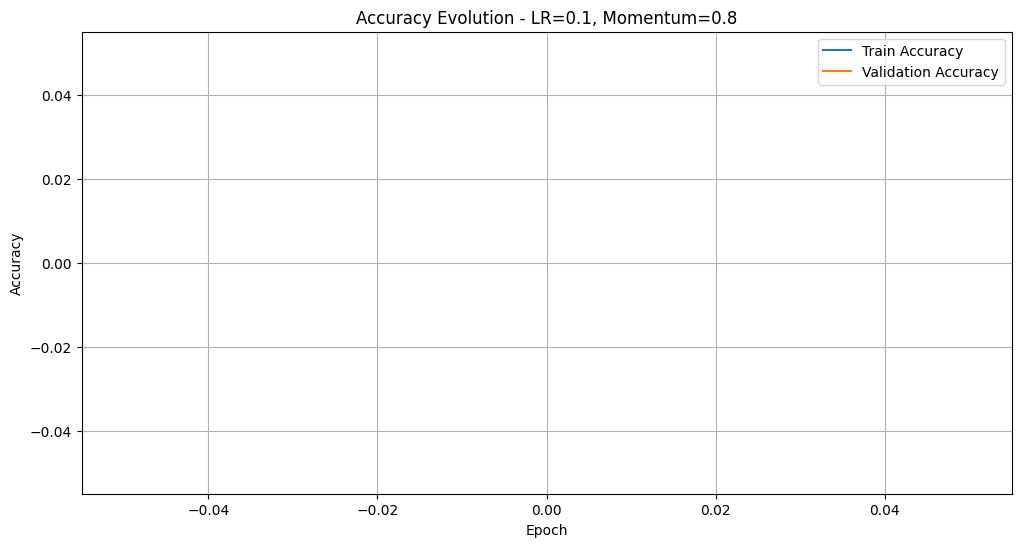

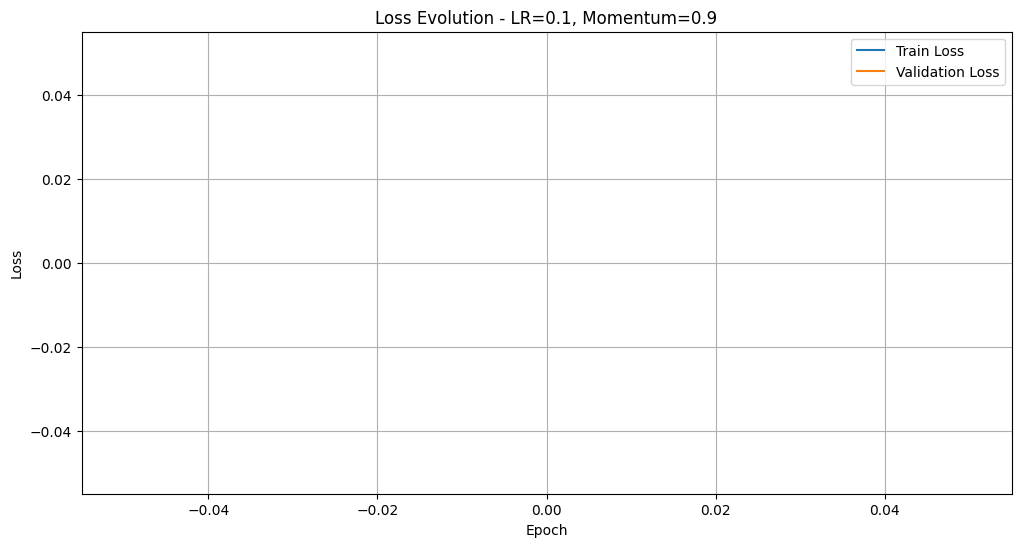

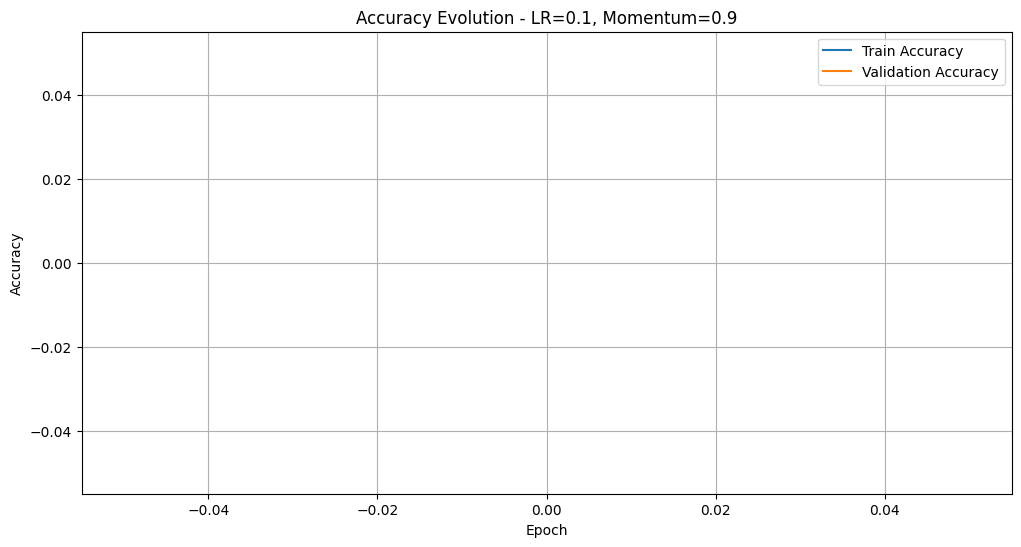

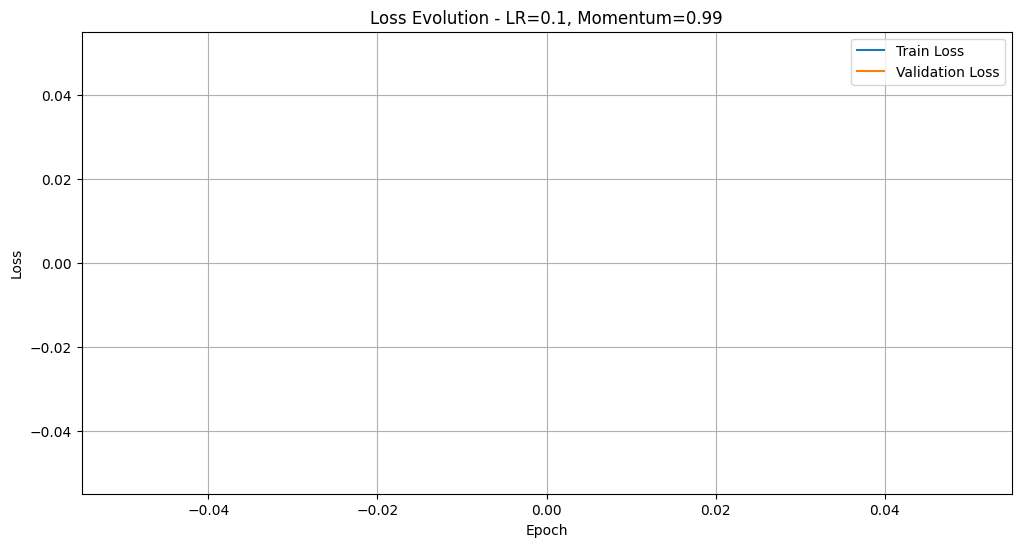

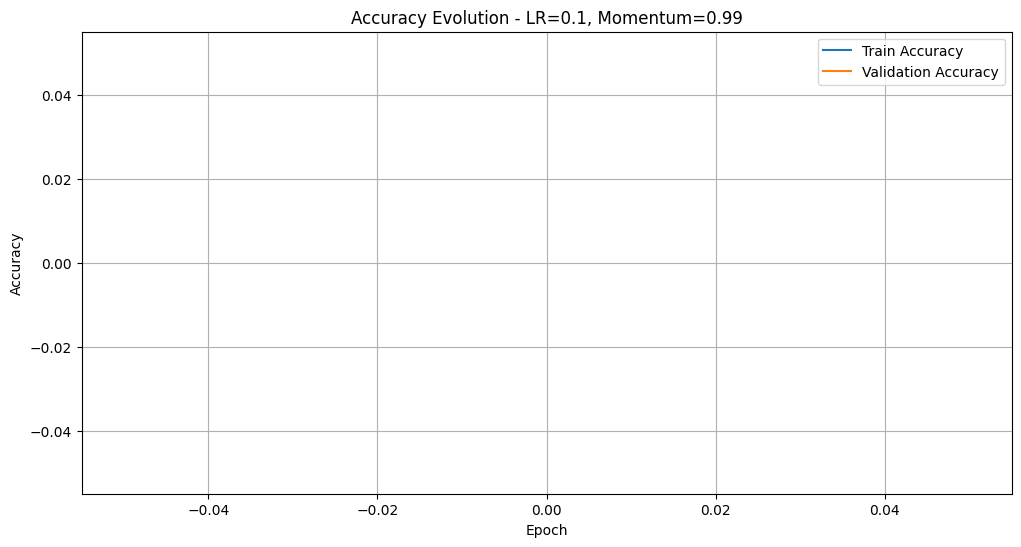

In [101]:
import matplotlib.pyplot as plt

# Parámetros para Early Stopping
iteracion_sin_mejora = 3  # Número de épocas sin mejora permitidas
best_hyperparameters = None
best_validation_accuracy_global = 0.0
metrics = {}  # Diccionario para almacenar métricas por combinación de (lr, momentum)

# Loop para probar combinaciones de learning_rate y momentum
for lr in aprendizaje:
    for mm in momentums:
        print(f"\n------- Probando combinación: learning_rate={lr}, momentum={mm} -------")

        # Configurar optimizador con los valores actuales
        optimizer = torch.optim.SGD(parametros, lr=lr, momentum=mm)

        # Reiniciar métricas y variables
        train_losses = []
        train_accuracies = []
        valid_losses = []
        valid_accuracies = []
        best_validation_accuracy = 0.0
        epochs_without_improvement = 0

        # Entrenamiento con Early Stopping
        for epoch in range(epoch):
            ce = 0.0  # Pérdida acumulada
            acc = 0.0  # Precisión acumulada

            # Entrenamiento por lotes
            for x_batch, y_batch in train_loader:
                y_pred = forward(x_batch)  # Forward
                loss = perdida(y_pred, y_batch)  # Pérdida
                accuracy = precision(y_pred, y_batch)  # Precisión del mini-lote

                # Gradientes y optimización
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()

                ce += loss.item()
                acc += accuracy

            # Guardar métricas de entrenamiento
            train_losses.append(ce / len(train_loader))
            train_accuracies.append(acc / len(train_loader))

            # Evaluación en el conjunto de validación
            test_loss = 0.0
            test_acc = 0.0
            for x_test, y_test in valid_loader:
                y_pred = forward(x_test)
                test_loss += perdida(y_pred, y_test).item()
                test_acc += precision(y_pred, y_test)

            # Guardar métricas de validación
            valid_losses.append(test_loss / len(valid_loader))
            valid_accuracies.append(test_acc / len(valid_loader))

            # Early Stopping
            if test_acc / len(valid_loader) > best_validation_accuracy:
                best_validation_accuracy = test_acc / len(valid_loader)
                epochs_without_improvement = 0
            else:
                epochs_without_improvement += 1

            if epochs_without_improvement >= iteracion_sin_mejora:
                print(f"*** Early stopping activado para LR={lr}, Momentum={mm} ***")
                break

        # Guardar métricas de esta combinación
        metrics[(lr, mm)] = {
            "train_losses": train_losses,
            "valid_losses": valid_losses,
            "train_accuracies": train_accuracies,
            "valid_accuracies": valid_accuracies
        }

        # Comparar la precisión de validación con la mejor global
        if best_validation_accuracy > best_validation_accuracy_global:
            best_validation_accuracy_global = best_validation_accuracy
            best_hyperparameters = (lr, mm)

# Resultado final
if best_hyperparameters is not None:
    print(f"\n------- Mejor combinación encontrada -------")
    print(f"Learning Rate: {best_hyperparameters[0]}, Momentum: {best_hyperparameters[1]}, "
          f"Validation Accuracy: {best_validation_accuracy_global * 100:.2f}%")
else:
    print("\nNo se encontró ninguna combinación con mejora en validación.")

# Generación de gráficas de precisión y pérdida
for (lr, mm), data in metrics.items():
    epochs = range(1, len(data["train_losses"]) + 1)

    # Gráfica de pérdida
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, data["train_losses"], label="Train Loss")
    plt.plot(epochs, data["valid_losses"], label="Validation Loss")
    plt.title(f"Loss Evolution - LR={lr}, Momentum={mm}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()

    # Gráfica de precisión
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, data["train_accuracies"], label="Train Accuracy")
    plt.plot(epochs, data["valid_accuracies"], label="Validation Accuracy")
    plt.title(f"Accuracy Evolution - LR={lr}, Momentum={mm}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()
    plt.show()


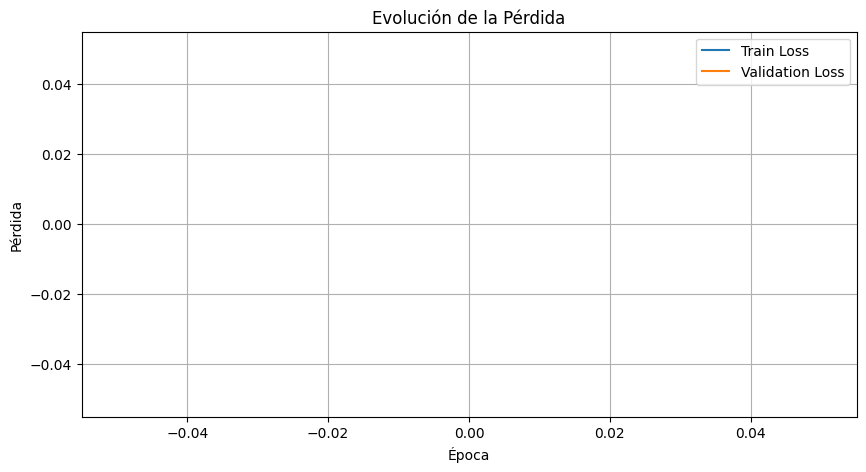

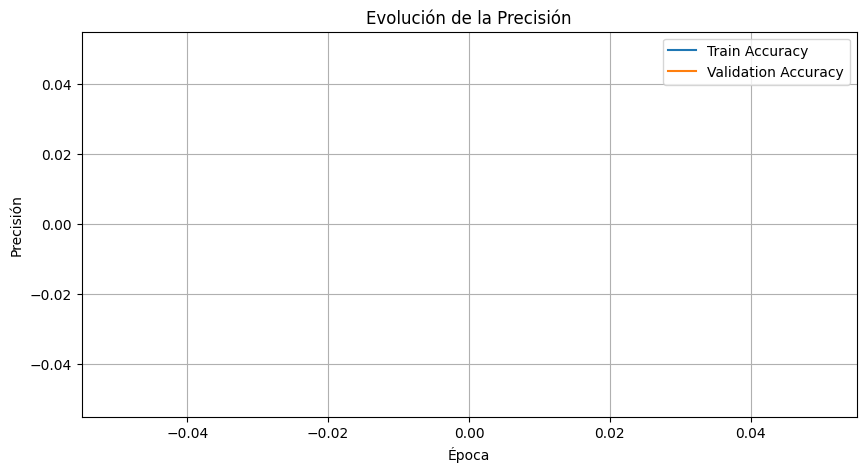

In [102]:
# Gráfica de la pérdida
plt.figure(figsize=(10, 5))
plt.plot(range(1, epoch + 1), train_losses, label='Train Loss')
plt.plot(range(1, epoch + 1), valid_losses, label='Validation Loss')
plt.title('Evolución de la Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid()
plt.show()

# Gráfica de la precisión
plt.figure(figsize=(10, 5))
plt.plot(range(1, epoch + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, epoch + 1), valid_accuracies, label='Validation Accuracy')
plt.title('Evolución de la Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid()
plt.show()


In [103]:
# Verificar y convertir datos si es necesario
if not isinstance(x_train, torch.Tensor):
    x_train_tensor = torch.from_numpy(x_train).float().to('mps')
else:
    x_train_tensor = x_train.float().to('mps')

if not isinstance(y_train, torch.Tensor):
    y_train_tensor = torch.from_numpy(y_train).long().to('mps')
else:
    y_train_tensor = y_train.long().to('mps')

if not isinstance(x_valid, torch.Tensor):
    x_valid_tensor = torch.from_numpy(x_valid).float().to('mps')
else:
    x_valid_tensor = x_valid.float().to('mps')

if not isinstance(y_valid, torch.Tensor):
    y_valid_tensor = torch.from_numpy(y_valid).long().to('mps')
else:
    y_valid_tensor = y_valid.long().to('mps')



------- Probando combinación: learning_rate=0.001, momentum=0.8 -------

------- Probando combinación: learning_rate=0.001, momentum=0.9 -------

------- Probando combinación: learning_rate=0.001, momentum=0.99 -------

------- Probando combinación: learning_rate=0.01, momentum=0.8 -------

------- Probando combinación: learning_rate=0.01, momentum=0.9 -------

------- Probando combinación: learning_rate=0.01, momentum=0.99 -------

------- Probando combinación: learning_rate=0.1, momentum=0.8 -------

------- Probando combinación: learning_rate=0.1, momentum=0.9 -------

------- Probando combinación: learning_rate=0.1, momentum=0.99 -------


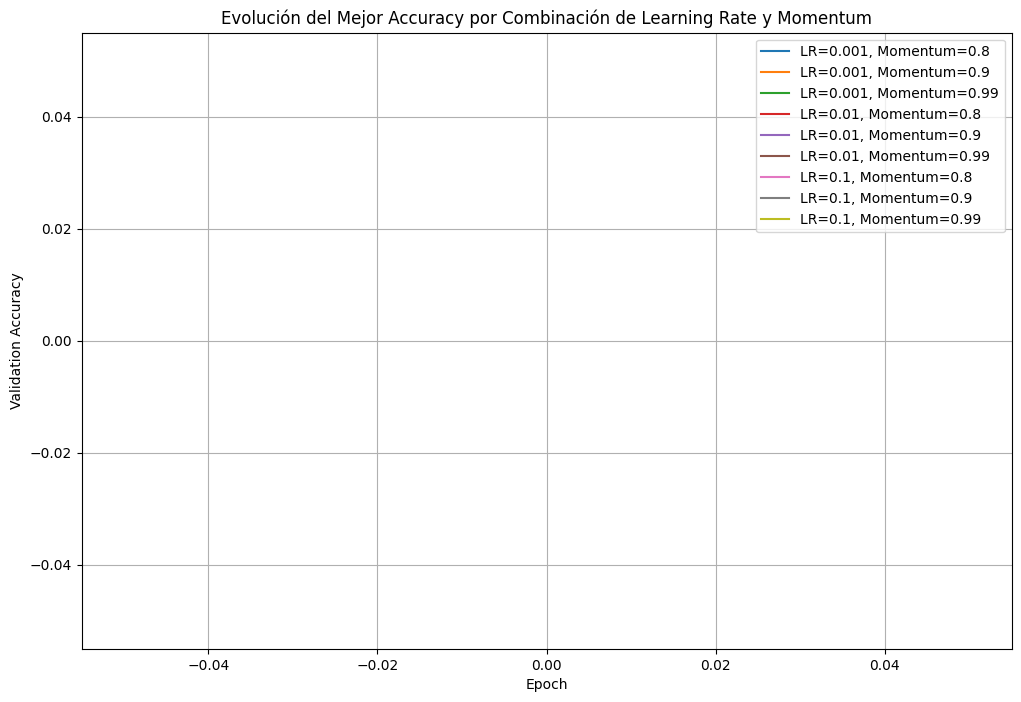

In [104]:
import matplotlib.pyplot as plt

# Diccionario para almacenar el mejor accuracy por combinación de (learning_rate, momentum)
best_accuracies = {}

# Loop para probar combinaciones de learning_rate y momentum
for lr in aprendizaje:
    for mm in momentums:
        print(f"\n------- Probando combinación: learning_rate={lr}, momentum={mm} -------")

        # Configurar optimizador
        optimizer = torch.optim.SGD(parametros, lr=lr, momentum=mm)

        # Variables para almacenar el mejor accuracy y su evolución
        valid_accuracies = []
        best_accuracy_for_combination = 0.0

        # Entrenamiento con Early Stopping
        for epoch in range(epoch):
            # Evaluación en el conjunto de validación
            test_acc = 0.0
            for x_test, y_test in valid_loader:
                y_pred = forward(x_test)
                test_acc += precision(y_pred, y_test)

            current_accuracy = test_acc / len(valid_loader)
            valid_accuracies.append(current_accuracy)

            # Verificar si esta combinación mejora
            if current_accuracy > best_accuracy_for_combination:
                best_accuracy_for_combination = current_accuracy

        # Guardar el mejor accuracy para esta combinación
        best_accuracies[(lr, mm)] = valid_accuracies

# Generación del gráfico
plt.figure(figsize=(12, 8))
for (lr, mm), accuracies in best_accuracies.items():
    epochs = range(1, len(accuracies) + 1)
    plt.plot(epochs, accuracies, label=f"LR={lr}, Momentum={mm}")

plt.title("Evolución del Mejor Accuracy por Combinación de Learning Rate y Momentum")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

In [105]:
# -*- coding: utf-8 -*-
# Author: [Tu Nombre]

import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import functional as F
import torch.nn as nn
import random
import copy
import pandas as pd
import matplotlib.pyplot as plt

# Configuración de la semilla para reproducibilidad
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Hiperparámetros
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 0.01
MOMENTUM = 0.9
patience = 3

# Datos de entrada (suponiendo que ya están definidos: x_train, y_train, x_valid, y_valid)

# Crear TensorDatasets
tensor_train = TensorDataset(x_train_tensor, y_train_tensor)
tensor_valid = TensorDataset(x_valid_tensor, y_valid_tensor)

# Crear DataLoaders
train_loader = DataLoader(tensor_train, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(tensor_valid, batch_size=BATCH_SIZE, shuffle=False)

# Inicialización de pesos y sesgos
w1 = torch.from_numpy(np.random.normal(0, np.sqrt(2.0 / (3 * 3 * 1)), (32, 1, 3, 3)).astype('float32')).to('mps').requires_grad_()
b1 = torch.zeros((32,), dtype=torch.float32).to('mps').requires_grad_()
w2 = torch.from_numpy(np.random.normal(0, np.sqrt(2.0 / (3 * 3 * 32)), (64, 32, 3, 3)).astype('float32')).to('mps').requires_grad_()
b2 = torch.zeros((64,), dtype=torch.float32).to('mps').requires_grad_()
w_dense = torch.from_numpy(np.random.normal(0, np.sqrt(2.0 / 36864), (36864, 1)).astype('float32')).to('mps').requires_grad_()
b_dense = torch.zeros((1,), dtype=torch.float32).to('mps').requires_grad_()
parameters = [w1, b1, w2, b2, w_dense, b_dense]

# Funciones auxiliares
def activation(x, func):
    if func == "relu":
        return F.relu(x)
    elif func == "sigmoid":
        return torch.sigmoid(x)
    else:
        raise ValueError("Función de activación no soportada")

def forward(x):
    x = F.conv2d(x, w1, b1, stride=1, padding=0)
    x = activation(x, 'relu')
    x = F.conv2d(x, w2, b2, stride=1, padding=0)
    x = activation(x, 'relu')
    x = x.view(x.size(0), -1)
    logits = x @ w_dense + b_dense
    return logits

def perdida(y_pred, y_true):
    y_true = y_true.unsqueeze(-1)
    return F.binary_cross_entropy_with_logits(y_pred, y_true.float())

# Optimización
optimizer = torch.optim.SGD(parametros, lr=LEARNING_RATE, momentum=MOMENTUM)

# Almacenar métricas y variaciones
epoch_data = []
weight_variations = []
bias_variations = []

# Entrenamiento
for epoch in range(EPOCHS):
    ce = 0.0
    for x_batch, y_batch in train_loader:
        y_pred = forward(x_batch)
        loss = perdida(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        ce += loss.item()
    
    # Almacenar datos del coste
    epoch_cost = ce / len(train_loader)
    epoch_data.append({"epoch": epoch + 1, "cost": epoch_cost})
    
    # Almacenar valores de pesos y sesgos
    weight_variations.append([w1.clone().detach().cpu().numpy().mean(),
                              w2.clone().detach().cpu().numpy().mean(),
                              w_dense.clone().detach().cpu().numpy().mean()])
    bias_variations.append([b1.clone().detach().cpu().numpy().mean(),
                            b2.clone().detach().cpu().numpy().mean(),
                            b_dense.clone().detach().cpu().numpy().mean()])
    
    print(f"Epoch {epoch + 1}/{EPOCHS}, Cost: {epoch_cost:.4f}")

# Crear tabla de costes
df = pd.DataFrame(epoch_data)
print("\nTabla de costes:")
print(df)

# Graficar la variación de los pesos
weight_variations = np.array(weight_variations)
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), weight_variations[:, 0], label="w1")
plt.plot(range(1, EPOCHS + 1), weight_variations[:, 1], label="w2")
plt.plot(range(1, EPOCHS + 1), weight_variations[:, 2], label="w_dense")
plt.title("Variación de los pesos por época")
plt.xlabel("Épocas")
plt.ylabel("Media de los pesos")
plt.legend()
plt.show()

# Graficar la variación de los sesgos
bias_variations = np.array(bias_variations)
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), bias_variations[:, 0], label="b1")
plt.plot(range(1, EPOCHS + 1), bias_variations[:, 1], label="b2")
plt.plot(range(1, EPOCHS + 1), bias_variations[:, 2], label="b_dense")
plt.title("Variación de los sesgos por época")
plt.xlabel("Épocas")
plt.ylabel("Media de los sesgos")
plt.legend()
plt.show()


Epoch 1/50, Cost: 0.7030


KeyboardInterrupt: 